In [1]:
import numpy as np

In [2]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [4]:
from wolensing.plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af

In [5]:
import sys
import os
path = os.getcwd()
dir = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(dir)

In [6]:
import amplification_factor.amplification_factor as af
from utils.utils import Morse_indices

The macroimage where the microlens is placed around.

In [7]:
type2 = False

In [8]:
ym = .5
angle = np.radians(float(0))

Importing constants

In [9]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [10]:
y0, y1 = 0.1, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [11]:
mL1 = 1 * 1e10
mL2 = 100
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [12]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]

# Injecting microlens around desired macroimage
eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
lens_model_list = ['SIS', 'POINT_MASS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 10 * thetaE2,
                 'Pixels': 1e3,
                 'OverlapDist': 1e-18,
                 'OverlapDistMacro': 1e-17}
solver_kwargs.update({'Improvement' : 0.1})
solver_kwargs.update({'MinDist' : 10**(-7)})

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                                      source_pos_y=beta1,
                                                                      lens_model_list=lens_model_list,
                                                                      kwargs_lens=kwargs_lens_list,
                                                                      **solver_kwargs)
Images_dict = {'Source_ra': beta0,
               'Source_dec': beta1,
               'Img_ra': Img_ra,
               'Img_dec': Img_dec,
               'MacroImg_ra': MacroImg_ra,
               'MacroImg_dec': MacroImg_dec,
               'Microlens_ra': [eta20],
               'Microlens_dec': [eta21],
               'thetaE': thetaE}

# time delays, magnifications, Morse indices 
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
print('Time delays (seconds): ', tds)
print('magnifications: ', mus)
print('Morse indices: ', ns)
    
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
if not isinstance(T0, float):
    T0 = T0[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.05288806158241e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-7.24759925e-07  8.85817687e-07]
dec: [4.23516474e-22 4.23516474e-22]


---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> False
Scaled            --> False
SearchWindowMacro --> 8.05288806158241e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-7.24759925e-07  8.85817687e-07]
dec: [4.23516474e-22 4.23516474e-22]


---- Solver settings ----

Th

In [13]:
# plot only the microimages around the desired macroimage
Img_ra = np.delete(Img_ra, [0])
Img_dec = np.delete(Img_dec, [0])

[-7.24759925e-07  8.85817687e-07] [4.23516474e-22 4.23516474e-22] Img_pos


<AxesSubplot:>

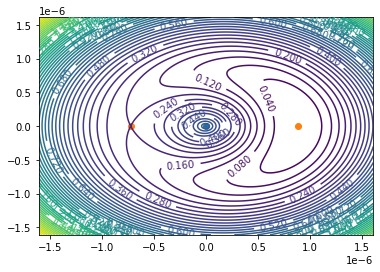

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_contour(ax, lens_model_list, eta10, eta11, 4*thetaE1, kwargs_lens_list, beta0, beta1, MacroImg_ra, MacroImg_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=False)


[8.85813622e-07 8.85754812e-07 8.85920827e-07 8.85813622e-07] [-2.63385676e-10  3.59737393e-22  3.59737393e-22  2.63385676e-10] Img_pos


<AxesSubplot:>

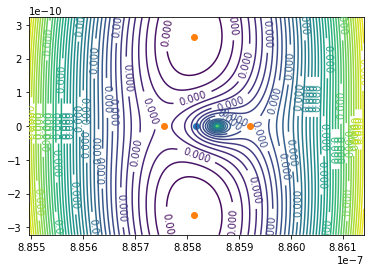

In [15]:
fig1, ax1 = plt.subplots()
plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 8*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=True)


In [16]:
# Define the characteristic WindowSize
mL3 = 10
thetaE3 = param_processing(zL, zS, mL3)

In [17]:
import time

bin -0.6000001075663833 -0.5999963853994519
<lenstronomy.LensModel.lens_model.LensModel object at 0x7fac74572c50> 5 [[None None]] 2000 0 8.83143813034927e-07 -2.67387414178234e-09 1.069656622375343e-09 110000 -0.6000001075663833 -0.5999963853994519 8.05288810184685e-07 [{'center_x': 0.0, 'center_y': 0.0, 'theta_E': 8.05288806158241e-07}, {'center_x': 8.858579516170178e-07, 'center_y': 4.235164736271502e-22, 'theta_E': 8.052888061582409e-11}] 8.05288810184685e-08 0.0 5.348283111876715e-13
start


Integrating...: 100%|██████████| 36/36 [00:11<00:00,  3.13it/s]


9999 1 110000
total time 3.9999900000000004
-13.530758142471313


<Figure size 432x288 with 0 Axes>

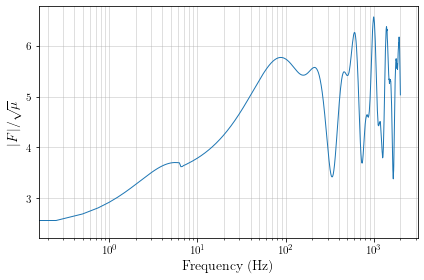

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [18]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': Mus[microtype],
               }

kwargs_integrator = {'PixelNum': int(10000),
                     'PixelBlockMax': 2000,
                     'WindowSize': 1.*210*thetaE3,
                     'WindowCenterX': MacroImg_ra[microtype],
                     'WindowCenterY': MacroImg_dec[microtype],
                     'T0': T0,
                     'TimeStep': 1e-5/Tscale, 
                     'TimeMax': T0 + 1/Tscale,
                     'TimeMin': T0 - .1/Tscale,
                     'TimeLength': .13/Tscale,
                     'TExtend': 3.87/Tscale,
                     'LastImageT': .02/Tscale,
                     'Tbuffer': 0,
                     'Tscale': Tscale}


amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
start = time.time()
ts, F_tilde = amplification.integrator(gpu=True)
ws, Fws = amplification.fourier()
end = time.time()
print(start-end)
amplification.plot_freq()

In [19]:
lens_model_list

['SIS', 'POINT_MASS']

In [20]:
tds = np.delete(tds, [0])
ns = np.delete(ns, [0])
mus = np.delete(mus, [0])

In [21]:
tds

array([0.        , 0.00227206, 0.00525785, 0.        ])

In [22]:
np.amax(tds)

0.0052578542090486735

In [23]:
ns = [0,0.5,0.5,0]

In [24]:
ns1 = Morse_indices(lens_model_list, Img_ra, Img_dec, kwargs_lens_list)

[0.9141033  0.17680165 0.02948676]
[ 1.60961180e+00 -5.18767237e-01  7.54308971e-13]
[ 2.64038820e+00 -1.54937327e+00 -3.32757897e-12]
[ 0.9141033   0.17680165 -0.02948676]


In [25]:
fs = ws/(2*np.pi)

In [26]:
wsm = int(5/np.amax(tds))
index = (np.abs(fs-wsm)).argmin()
index

3800

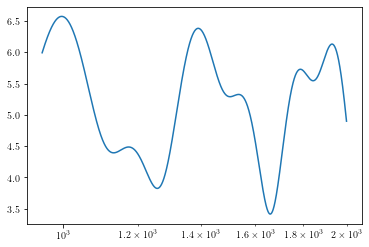

In [27]:
freq = fs[index:]
from lensinggw.amplification_factor.amplification_factor import amplification_from_data
Fmag = amplification_from_data(freq, mus, tds, ns)
import matplotlib.pyplot as plt
plt.semilogx(freq, np.abs(Fmag))

In [28]:
Full_Fws = np.concatenate((np.abs(Fws[:index]), np.abs(Fmag)))

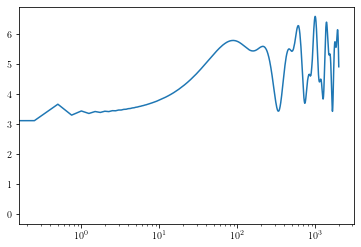

In [29]:
plt.semilogx(fs, Full_Fws)

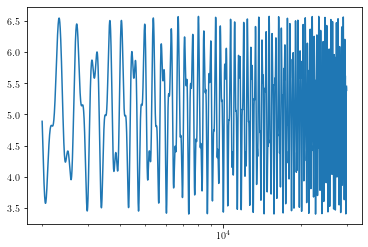

In [30]:
freq1 = np.linspace(2000, 30000, 20000)
from lensinggw.amplification_factor.amplification_factor import amplification_from_data
Fmag1 = amplification_from_data(freq1, mus, tds, ns)
import matplotlib.pyplot as plt
plt.semilogx(freq1, np.abs(Fmag1))

In [31]:
Full_Fws1 = np.concatenate((np.abs(Fws[:index]), np.abs(Fmag), np.abs(Fmag1)))

In [32]:
fs1 = np.concatenate((fs, freq1))

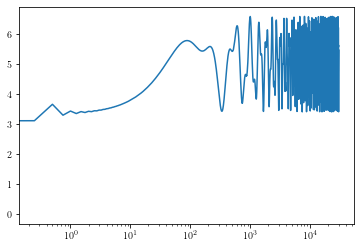

In [33]:
plt.semilogx(fs1, Full_Fws1)

In [34]:
np.angle(Fmag)

array([-0.18286785, -0.18216015, -0.18144733, ...,  0.32063794,
        0.32087935,  0.32111201])

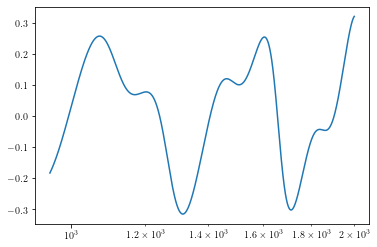

In [35]:
plt.semilogx(freq, np.angle(Fmag))

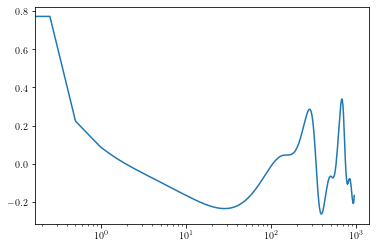

In [36]:
plt.semilogx(fs[:index], np.angle(Fws[:index]))

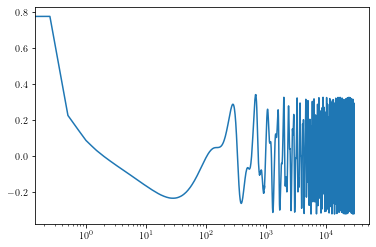

In [37]:
Full_pha_Fws1 = np.concatenate((np.angle(Fws[:index]), np.angle(Fmag), np.angle(Fmag1)))
plt.semilogx(fs1, Full_pha_Fws1)

[0.9141033  0.17680165 0.02948676]
[ 1.60961180e+00 -5.18767237e-01  7.54308971e-13]
[ 2.64038820e+00 -1.54937327e+00 -3.32757897e-12]
[ 0.9141033   0.17680165 -0.02948676]


/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


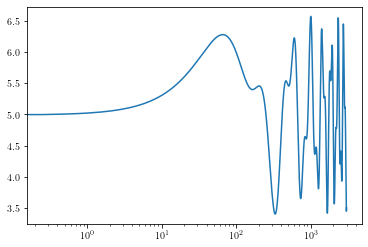

In [38]:
geofs, geoFws = amplification.geometrical_optics(mus, tds, Img_ra, Img_dec)
plt.semilogx(geofs, geoFws)

<Figure size 432x288 with 0 Axes>

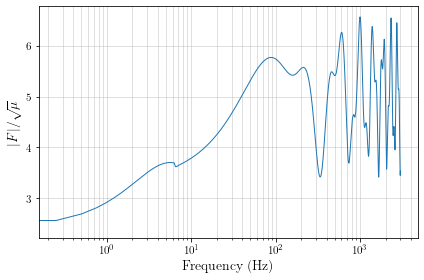

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [39]:
fullfs, fullFws = amplification.concatenate()
amplification.importor(fs=fullfs, Fws = fullFws, freq=True)
amplification.plot_freq(freq_end = 3000)

/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


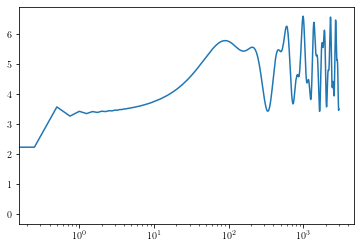

In [40]:
plt.semilogx(fullfs, fullFws)

In [41]:
geofs[0]

0.0

In [ ]:
amplification._ws[4000]/(2*np.pi)